# Train a neural network.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Set parameters

In [2]:
# file with training input and output data: format is x,y
input_file = 'RampSuccessData.csv'

# names of input/output columns
inputs = ['length', 'angle']
outputs = ['success']#['low_speed', 'high_speed']

# these set the input/output dimensions of the network
input_size = len(inputs)
output_size = len(outputs)

Read data

In [3]:
data = pd.read_csv(input_file)
data.columns = inputs + outputs

x = np.array(data[inputs])
y = np.array(data[outputs])

Normalizing preprocessing layer from training data

In [4]:
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(x)

Penalize overpredictions more than underpredictions

In [5]:
def asymmetric_mse(y_true, y_pred):
    standard_mse = keras.losses.mse(y_true, y_pred)
    geq = keras.backend.any(keras.backend.greater(y_pred, y_true)) # true/false, are there overpredictions?
    geq_scale = keras.backend.switch(geq,5.0,1.0) # if there are overpredictions, scale up mse
    return geq_scale * standard_mse

Base model

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(4, activation='linear',input_dim=input_size,kernel_regularizer=keras.regularizers.l2(0.0000001)))
model.add(keras.layers.Dense(20,activation='relu'))
model.add(keras.layers.Dense(20,activation='relu'))
model.add(keras.layers.Dense(output_size,activation='sigmoid'))
model.compile(loss=asymmetric_mse,optimizer='adam')

Compile model

In [15]:
input_shape = x.shape[1:]
full_model_input = keras.Input(shape=input_shape)
normalized_input = normalizer(full_model_input)
full_model_output = model(normalized_input)
full_model = keras.Model(full_model_input, full_model_output)
full_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy'])

Split data

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, shuffle= True)

Train model

In [17]:
model_output = full_model.fit(x_train,y_train,epochs=400,batch_size=10,verbose=0,validation_data=(x_val,y_val)) # check validation

View training

<Figure size 432x288 with 0 Axes>

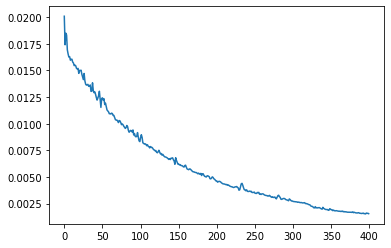

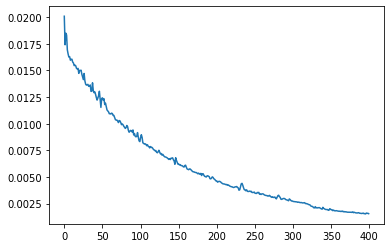

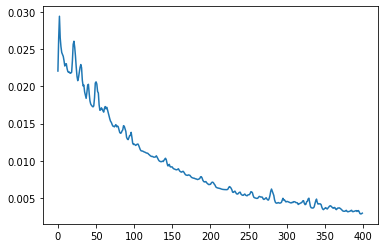

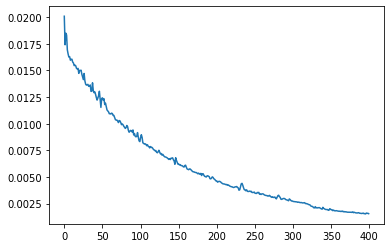

<Figure size 432x288 with 0 Axes>

In [21]:
#plt.yscale('log')
plt.plot(model_output.history['loss'])
plt.figure()
#plt.yscale('log')
plt.plot(model_output.history['binary_crossentropy'])
plt.figure()
#plt.yscale('log')
plt.plot(model_output.history['val_loss'])
plt.figure()
#plt.yscale('log')
plt.plot(model_output.history['binary_crossentropy'])
plt.figure()

View output

In [ ]:
# plot speed vs angle given mu, threshold
mu = 1 # set mu
thresh = 4 # set threshold

# bug: mu = 0.009 is read as 0.0090..01
#plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
plot_x = [i for i in x if np.isclose(i[0], mu) and i[2] == thresh] # x, y
# this is not generic enough...
pred_x = [[mu,angle,thresh] for angle in np.linspace(0,165,165)]
pred = full_model.predict(pred_x)

#plt.plot([i[1] for i in plot_values], [y[i] for i,v in enumerate(x) if v[0] == mu and v[2] == thresh])
plt.plot([i[1] for i in plot_x], [y[i] for i,v in enumerate(x) if np.isclose(v[0], mu) and v[2] == thresh])
plt.plot([i[1] for i in pred_x], pred)

Save model

In [22]:
full_model.save("ramp_network.h5")

Find largest divergence between prediction and training data

In [ ]:
divergence = (full_model.predict(x) - y)
print(max(divergence), x[np.where(divergence == max(divergence))[0]])

Make a lot of plots

In [ ]:
# mus = data['mu'].unique()
# angles = data['angle'].unique()
# thresholds = data['threshold'].unique()
# a=0
# # plot speed vs angle given mu, threshold
# for mu in mus:
#     for threshold in thresholds:
#         # bug: mu = 0.009 is read as 0.0090..01
#         #plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
#         plot_x = [i for i in x if np.isclose(i[0], mu) and i[2] == threshold] # x, y
#         pred_x = [[mu,angle,threshold] for angle in np.linspace(angles.min(),angles.max(),angles.max())]
#         pred = full_model.predict(pred_x)
#         #plt.plot([i[1] for i in plot_values], [y[i] for i,v in enumerate(x) if v[0] == mu and v[2] == thresh])
#         fig = plt.figure()
#         plt.title('mu: %.3f, threshold: %.2f' % (mu, threshold))
#         plt.plot([i[1] for i in plot_x], [y[i] for i,v in enumerate(x) if np.isclose(v[0], mu) and v[2] == threshold])
#         plt.plot([i[1] for i in pred_x], pred)
#         plt.savefig('plots/mu-%.3f_threshold-%.2f.png' % (mu,threshold))
#         plt.close()